In [1]:
# NUMBER OF RUNS FOR EACH OPTUNA ITERATION:
# - the number of optuna trials is computed as 1500 // n_runs
n_runs = 10

# AGGREGATION METHOD:
# - 'aggregate': aggregates the MultiSim object on the mean values and computes a single loss
# - 'average': computes the loss of each simulation in the MultiSim and the averages the n_runs losses
method = 'average'

In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install covasim==2.0.3 optuna
    !git clone https://github.com/mazzio97/EpidemicModelLearning.git
    sys.path.append('EpidemicModelLearning/')    

In [3]:
import optuna as op
import covasim as cv
import seaborn as sns
import matplotlib.pyplot as plt
from src import data, calibration, interventions

sns.set_context('notebook')
sns.set_style('whitegrid')

# NUMBER OF TOTAL SIMULATIONS
n_simulations = 1500

# NUMBER OF OPTUNA TRIALS
n_trials = n_simulations // n_runs

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


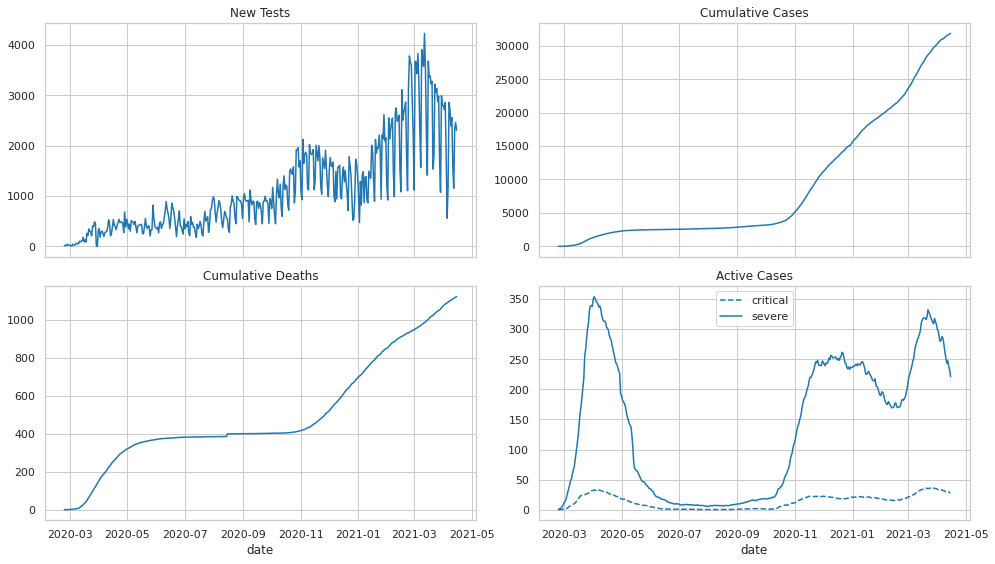

In [4]:
pop_size = 400e3
pop_scale = 10
cols = ['n_severe', 'n_critical', 'cum_diagnoses', 'cum_deaths']
df = data.get_regional_data(scaling_factor=4.46e6/pop_size)

default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

_, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='all')
sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0, 0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_diagnoses', ax=axes[0, 1]).set(title='Cumulative Cases', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1, 0]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_critical', label='critical', color='#1f77b4', linestyle='--', ax=axes[1, 1])
sns.lineplot(data=df, x='date', y='n_severe', label='severe', ax=axes[1, 1]).set(title='Active Cases', ylabel='')
plt.tight_layout()

In [5]:
def get_calibration_params(trial):
    return dict(
        pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2, step=5),
        **default_params
    ), dict(
        trace_prob=trial.suggest_float('trace_prob', 0.3, 0.9, step=1e-2),
        trace_time=trial.suggest_float('trace_time', 1.0, 5.0, step=1e-1),
        work_contacts=trial.suggest_float('work_contacts', 0.4, 0.9, step=1e-2),
        school_contacts=trial.suggest_float('school_contacts', 0.2, 0.8, step=1e-2),
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.6, 1.0, step=1e-2),
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.2, 0.8, step=1e-2),
        init_imports=trial.suggest_float('init_imports', 5.0, 15.0, step=1e-1),
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0, step=1e-1),
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0, step=1e-1),
        init_beta=trial.suggest_float('init_beta', 0.01, 0.02, step=None),
        summer_beta=trial.suggest_float('summer_beta', 0.002, 0.01, step=None),
        winter_beta=trial.suggest_float('winter_beta', 0.01, 0.02, step=None),
        init_symp=trial.suggest_float('init_symp', 0.5, 2.5, log=True),
        init_sev=trial.suggest_float('init_sev', 0.5, 2.0, log=True),
        init_crit=trial.suggest_float('init_crit', 0.5, 2.0, log=True),
        init_death=trial.suggest_float('init_death', 1.5, 4.5, log=True)
    )

In [6]:
constraint_orderings = [
    ('yellow_casual_contacts', 'orange_casual_contacts'),
    ('init_imports', 'yellow_imports', 'orange_imports'),
    ('init_beta', 'summer_beta'),
    ('winter_beta', 'summer_beta')
]

def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.get_calibration_interventions(intervention_params)
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    violation = calibration.compute_violation(intervention_params, constraint_orderings)
    if method == 'aggregate':
        msim.mean()
        return violation * msim.base_sim.compute_fit(keys=cols, weights={k: 1 for k in cols}).mismatch
    if method == 'average':
        mismatches = [s.compute_fit(keys=cols, weights={k: 1 for k in cols}).mismatch for s in msim.sims]
        return violation * sum(mismatches) / n_runs
    else:
        raise ValueError("method should be either 'aggregate' or 'average'")

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-04-16 09:31:22,964] A new study created in memory with name: no-name-fbb1850d-f91c-421e-887d-9d33093b5625
[I 2021-04-16 09:32:50,359] Trial 0 finished with value: 4385.8014033063355 and parameters: {'pop_infected': 2915, 'trace_prob': 0.6599999999999999, 'trace_time': 2.7, 'work_contacts': 0.62, 'school_contacts': 0.45, 'yellow_casual_contacts': 0.6799999999999999, 'orange_casual_contacts': 0.42000000000000004, 'init_imports': 13.700000000000001, 'yellow_imports': 4.7, 'orange_imports': 6.1000000000000005, 'init_beta': 0.012394000155973693, 'summer_beta': 0.0075649611858311, 'winter_beta': 0.018080524478171232, 'init_symp': 1.2255034140717898, 'init_sev': 1.432672320421089, 'init_crit': 1.4520435512524725, 'init_death': 3.7492517497005733}. Best is trial 0 with value: 4385.8014033063355.
[I 2021-04-16 09:34:15,938] Trial 1 finished with value: 1658.5691494525395 and parameters: {'pop_infected': 2225, 'trace_prob': 0.69, 'trace_time': 3.6, 'work_contacts': 0.49, 'school_contacts

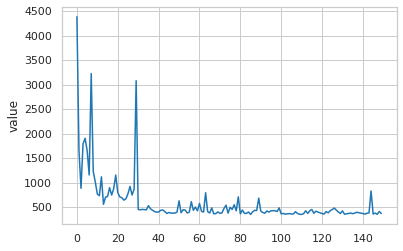

In [7]:
objectives = study.trials_dataframe()['value']
sns.lineplot(x=objectives.index, y=objectives)
plt.show()

In [8]:
calibration.inspect_study(study, top=10)[1]

,count,min,max,mean,median,std,best
objective,10,348.154376,357.123104,352.897108,352.889521,3.333131,348.154376
pop_infected,10,625.000000,950.000000,831.000000,862.500000,109.944430,625.000000
trace_prob,10,0.580000,0.660000,0.649000,0.660000,0.025144,0.580000
trace_time,10,4.600000,5.000000,4.790000,4.800000,0.159513,4.900000
work_contacts,10,0.570000,0.680000,0.630000,0.640000,0.032318,0.600000
school_contacts,10,0.650000,0.800000,0.763000,0.775000,0.044734,0.650000
yellow_casual_contacts,10,0.600000,0.750000,0.696000,0.700000,0.040879,0.600000
orange_casual_contacts,10,0.200000,0.400000,0.237000,0.225000,0.058319,0.400000
init_imports,10,6.300000,7.800000,6.800000,6.750000,0.449691,7.800000
yellow_imports,10,4.200000,6.400000,4.950000,4.750000,0.594886,6.400000


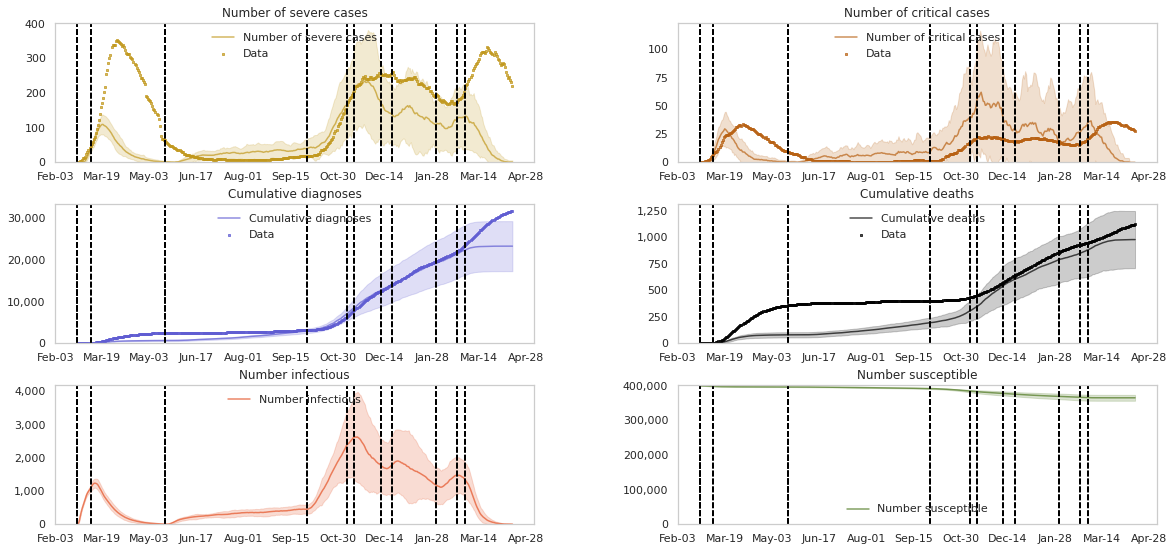

In [9]:
initial_params = {'pop_infected': study.best_params['pop_infected'], **default_params}
intervs = interventions.get_calibration_interventions(study.best_params)
sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)
msim.mean()
msim.plot(
    list(cols) + ['n_infectious', 'n_susceptible'],
    fig_args={'figsize': (18, 8)},
    scatter_args={'s': 5},
    plot_args={'lw': 2},
    interval=45
);